# Final Deliverable

**Final Deliverables (May 2)**

3. Clustering Modeling - April 21

  - Try K-Means

  - Use PCA or t-SNE for visualization.

  - Choose optimal clusters using silhouette or elbow method.
  
  - Evaluate model

4. Cluster Profiling - April 24

  - Analyze cluster composition: income, age, product preference.

  - Interpret clusters.

5. Business Insights - May 1

  - Recommend campaign strategies for each segment.

  - Finalize report with segment summaries and visualizations.
  

# Data Import

In [ ]:
import kagglehub
imakash3011_customer_personality_analysis_path = kagglehub.dataset_download('imakash3011/customer-personality-analysis')

print('Data source import complete.')

100%|██████████| 62.0k/62.0k [00:00<00:00, 8.11MB/s]

Extracting files...
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import os

# Find the CSV file path
file_path = None
for root, dirs, files in os.walk(imakash3011_customer_personality_analysis_path):
    for file in files:
        if file.endswith('.csv') or file.endswith('.txt'):
            file_path = os.path.join(root, file)
            break
    if file_path:
        break

df = pd.read_csv(file_path, sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# PreProcessing, Cleaning, Feature Selection, Feature Engineering

### Missing Values

In [ ]:
# Data Types and potential type conversions
print("\nData Types:")
df.info()



Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240

In [ ]:
# Missing Values
# Main issue is with income - we will imput these
print("\nMissing Values per column:")
print(df.isnull().sum())


Missing Values per column:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


#### Missing Value Insights:

* The dataset is quite clean to begin with. We are only missing values from the Income feature
* imputed with median

In [ ]:
# handle missing values for income, impute using median income
median_income = df['Income'].median()
df['Income'] = df['Income'].fillna(median_income)

### Feature Engineering

In [ ]:
#creating new features based on current features
df['TotalSpending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Age'] = 2025 - df['Year_Birth']
df['FamilySize_est'] = 1 + df['Kidhome'] + df['Teenhome']
df['Spending_Age_Interaction'] = df['TotalSpending'] * df['Age']
df['Income_FamilySize_Interaction'] = df['Income'] * df['FamilySize_est']
df['Income_FamilySize_Ratio'] = df['Income'] / df['FamilySize_est']

In [ ]:
#Convert 'Dt_Customer' to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Recency'] = (df['Dt_Customer'].max() - df['Dt_Customer']).dt.days

In [ ]:
#Deriving living situation by marital status "Partner" else "Alone"
df['Living_With'] = df['Marital_Status'].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Is_Parent
df['Is_Parent'] = np.where(df.FamilySize_est> 0, 1, 0)

#Segmenting education levels in three groups (Undergraduate, Graduate, Postgraduate)
df['Education'] = df['Education'].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#Drop unused features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID","Kidhome","Teenhome"]
df = df.drop(to_drop, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Education                      2240 non-null   object 
 1   Income                         2240 non-null   float64
 2   Recency                        2240 non-null   int64  
 3   MntWines                       2240 non-null   int64  
 4   MntFruits                      2240 non-null   int64  
 5   MntMeatProducts                2240 non-null   int64  
 6   MntFishProducts                2240 non-null   int64  
 7   MntSweetProducts               2240 non-null   int64  
 8   MntGoldProds                   2240 non-null   int64  
 9   NumDealsPurchases              2240 non-null   int64  
 10  NumWebPurchases                2240 non-null   int64  
 11  NumCatalogPurchases            2240 non-null   int64  
 12  NumStorePurchases              2240 non-null   i

In [ ]:
df_wrangled = pd.get_dummies(df, drop_first=True, columns=['Education','Living_With'],dtype=int)

All features encoded

In [ ]:
df_wrangled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Income                         2240 non-null   float64
 1   Recency                        2240 non-null   int64  
 2   MntWines                       2240 non-null   int64  
 3   MntFruits                      2240 non-null   int64  
 4   MntMeatProducts                2240 non-null   int64  
 5   MntFishProducts                2240 non-null   int64  
 6   MntSweetProducts               2240 non-null   int64  
 7   MntGoldProds                   2240 non-null   int64  
 8   NumDealsPurchases              2240 non-null   int64  
 9   NumWebPurchases                2240 non-null   int64  
 10  NumCatalogPurchases            2240 non-null   int64  
 11  NumStorePurchases              2240 non-null   int64  
 12  NumWebVisitsMonth              2240 non-null   i

#### Feature Engineering Insights:

* Again, the dataset to begin with is fairly clean, so our feature engineering a this point is farily simple
* We have started with a few obvious engineered features. We may continue to explore more complex interactions between features
* Few categorical features, dummy variable creation was limited to education and marital status features
* Additional feature engineering:
    1. Education level is grouped into 3 levels
    2. Marital status is changed to binary feature Living_With_Partner
    3. Is_Parent is derived from number of children
    4. Recency is days since customer signup

### Manage Outliers

In [ ]:
df_wrangled.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,TotalSpending,Age,FamilySize_est,Spending_Age_Interaction,Income_FamilySize_Interaction,Income_FamilySize_Ratio,Is_Parent,Education_Postgraduate,Education_Undergraduate,Living_With_Partner
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2240.0,2240.000000,2240.000000,2240.000000
mean,52237.975446,353.582143,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,...,605.798214,56.194196,1.950446,34845.327679,9.641483e+04,33782.527251,1.0,0.382143,0.114732,0.644643
std,25037.955891,202.122512,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,...,602.249288,11.984069,0.751803,36104.161424,5.256541e+04,25816.711199,0.0,0.486020,0.318770,0.478728
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,29.000000,1.000000,260.000000,1.730000e+03,1223.500000,1.0,0.000000,0.000000,0.000000
25%,35538.750000,180.750000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,...,68.750000,48.000000,1.000000,3591.000000,6.683250e+04,15449.125000,1.0,0.000000,0.000000,0.000000
50%,51381.500000,355.500000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,...,396.000000,55.000000,2.000000,21203.000000,8.660500e+04,24836.750000,1.0,0.000000,0.000000,1.000000
75%,68289.750000,529.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,...,1045.500000,66.000000,2.000000,58403.250000,1.249320e+05,38996.375000,1.0,1.000000,0.000000,1.000000
max,666666.000000,699.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,...,2525.000000,132.000000,4.000000,233478.000000,1.333332e+06,333333.000000,1.0,1.000000,1.000000,1.000000


#### Managing Outliers Insights:

* We found outliers in the age and income category - since the data is old, max age is 132 y/o, max income is 666666 - both are unrealistic, so we will set a cap max and drop those rows

In [ ]:
#Dropping the outliers by setting a max cap on age and income
df_wrangled = df_wrangled[(df_wrangled["Age"]<90)]
df_wrangled = df_wrangled[(df_wrangled["Income"]<600000)]
print("Total rows after removing outliers:", len(df_wrangled))

Total rows after removing outliers: 2236


### Data Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

#drop the features that will not be scaled
df2 = df_wrangled.copy()
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df2 = df2.drop(cols_del, axis=1)

scaler = StandardScaler()

# List of columns to scale (all except 'Education','Living_With_Partner' and 'Is_Parent')
columns_to_scale = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                    'NumStorePurchases', 'NumWebVisitsMonth', 'TotalSpending',
                    'Age', 'FamilySize_est', 'Spending_Age_Interaction',
                    'Income_FamilySize_Interaction', 'Income_FamilySize_Ratio']

# Fit the scaler on your data and transform
df_scaled = df2.copy()
scaled_features = scaler.fit_transform(df2[columns_to_scale])
df_scaled = pd.DataFrame(scaled_features, columns=columns_to_scale, index=df2.index)

In [ ]:
df_scaled.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,TotalSpending,Age,FamilySize_est,Spending_Age_Interaction,Income_FamilySize_Interaction,Income_FamilySize_Ratio
count,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2236.000000,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03,2.236000e+03
mean,-7.785464e-17,2.542192e-17,-7.944351e-18,-5.561046e-18,-3.177740e-17,4.289949e-17,2.065531e-17,4.766610e-18,1.271096e-17,0.000000,-7.308803e-17,-1.322734e-16,-1.525315e-16,4.766610e-18,6.514368e-17,-9.215447e-17,-3.336627e-17,-3.972175e-17,-6.991029e-17
std,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00
min,-2.346119e+00,-1.750171e+00,-9.037519e-01,-6.616104e-01,-7.400464e-01,-6.870194e-01,-6.558568e-01,-8.450157e-01,-1.203575e+00,-1.470716,-9.110556e-01,-1.783046e+00,-2.192136e+00,-9.987636e-01,-2.316276e+00,-1.264308e+00,-9.629404e-01,-2.063239e+00,-1.295393e+00
25%,-7.684571e-01,-8.559730e-01,-8.324330e-01,-6.364311e-01,-6.691367e-01,-6.321109e-01,-6.316380e-01,-6.721048e-01,-6.861374e-01,-0.751127,-9.110556e-01,-8.600834e-01,-9.557071e-01,-8.924037e-01,-6.924366e-01,-1.264308e+00,-8.698792e-01,-6.367234e-01,-7.272189e-01
50%,-2.667925e-02,1.101605e-02,-3.866896e-01,-4.601758e-01,-4.431121e-01,-4.673854e-01,-4.621065e-01,-3.839200e-01,-1.686996e-01,-0.031538,-2.268842e-01,-2.447750e-01,2.807217e-01,-3.481402e-01,-9.417994e-02,6.541573e-02,-3.779323e-01,-2.029999e-01,-3.520365e-01
75%,7.625254e-01,8.668740e-01,5.946886e-01,1.693073e-01,2.881439e-01,2.281224e-01,1.433631e-01,2.308744e-01,3.487383e-01,0.688050,4.572872e-01,6.781877e-01,6.928646e-01,7.304157e-01,8.459377e-01,6.541573e-02,6.581765e-01,6.370283e-01,2.123858e-01
max,5.159343e+00,1.707891e+00,3.532880e+00,4.349075e+00,6.904903e+00,4.053415e+00,5.713683e+00,6.109845e+00,6.557993e+00,8.243731,8.667344e+00,2.216459e+00,6.050723e+00,3.189157e+00,2.469777e+00,2.724862e+00,4.200143e+00,8.576804e+00,5.082558e+00


# Dimensionality Reduction

We have many features that we're working with, hence we are exploring dimensionality reduction with PCA to remove redundant features before we try to fit the data into a clustering model. The steps in this section are:
- Explore explained variance to choose an optimal number of components
- Visualize the new dataframe with appropriate principal components

In [ ]:
import matplotlib.pyplot as plt

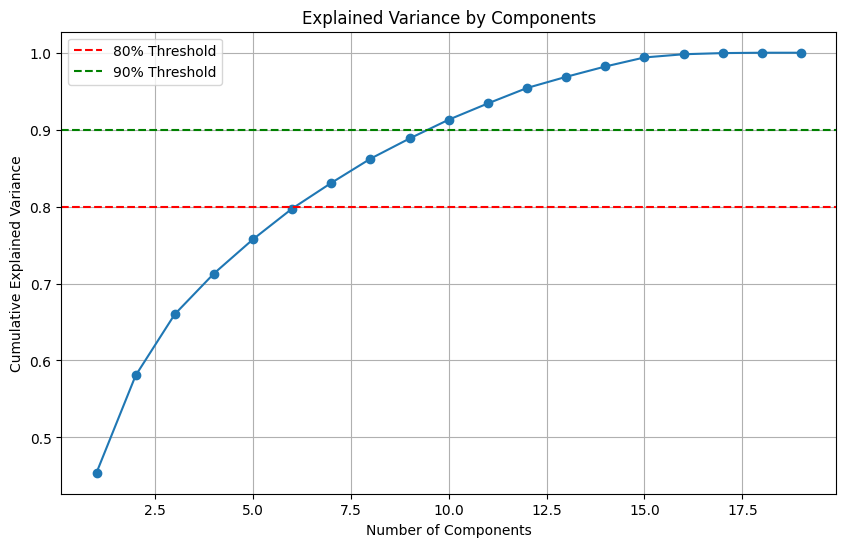

Number of components explaining 80% variance: 7


In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

pca_result = pca.fit_transform(df_scaled)

# Analyze explained variance to determine optimal number of components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Select components to explain 80% of variance
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components explaining 80% variance: {n_components}")


In [ ]:
# Create new PCA with chosen number of components
pca_final = PCA(n_components=n_components)
pca_result_final = pca_final.fit_transform(df_scaled)

# Create DataFrame with PCA results
pca_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(data=pca_result_final, columns=pca_columns, index=df_scaled.index)

In [ ]:
# Get feature importance (loadings)
feature_names = df_scaled.columns
loadings = pd.DataFrame(
    pca_final.components_.T,
    columns=pca_columns,
    index=feature_names
)

# Print absolute loadings for the first few components
print(loadings.abs().sort_values(by='PC1', ascending=False))

                                    PC1       PC2       PC3       PC4  \
TotalSpending                  0.326086  0.055583  0.069421  0.076208   
Spending_Age_Interaction       0.315062  0.092384  0.020131  0.221933   
Income_FamilySize_Ratio        0.296009  0.206710  0.086136  0.111021   
Income                         0.292624  0.098694  0.271070  0.027492   
MntMeatProducts                0.282401  0.082303  0.008408  0.010237   
NumCatalogPurchases            0.278912  0.022253  0.004640  0.053540   
MntWines                       0.269080  0.169720  0.053228  0.289796   
NumStorePurchases              0.246851  0.149286  0.004252  0.011820   
MntFishProducts                0.242923  0.085016  0.079835  0.294719   
MntFruits                      0.233131  0.075360  0.075566  0.358437   
MntSweetProducts               0.232245  0.057628  0.072423  0.352222   
NumWebVisitsMonth              0.217156  0.201946  0.405028  0.109689   
FamilySize_est                 0.196050  0.417078  

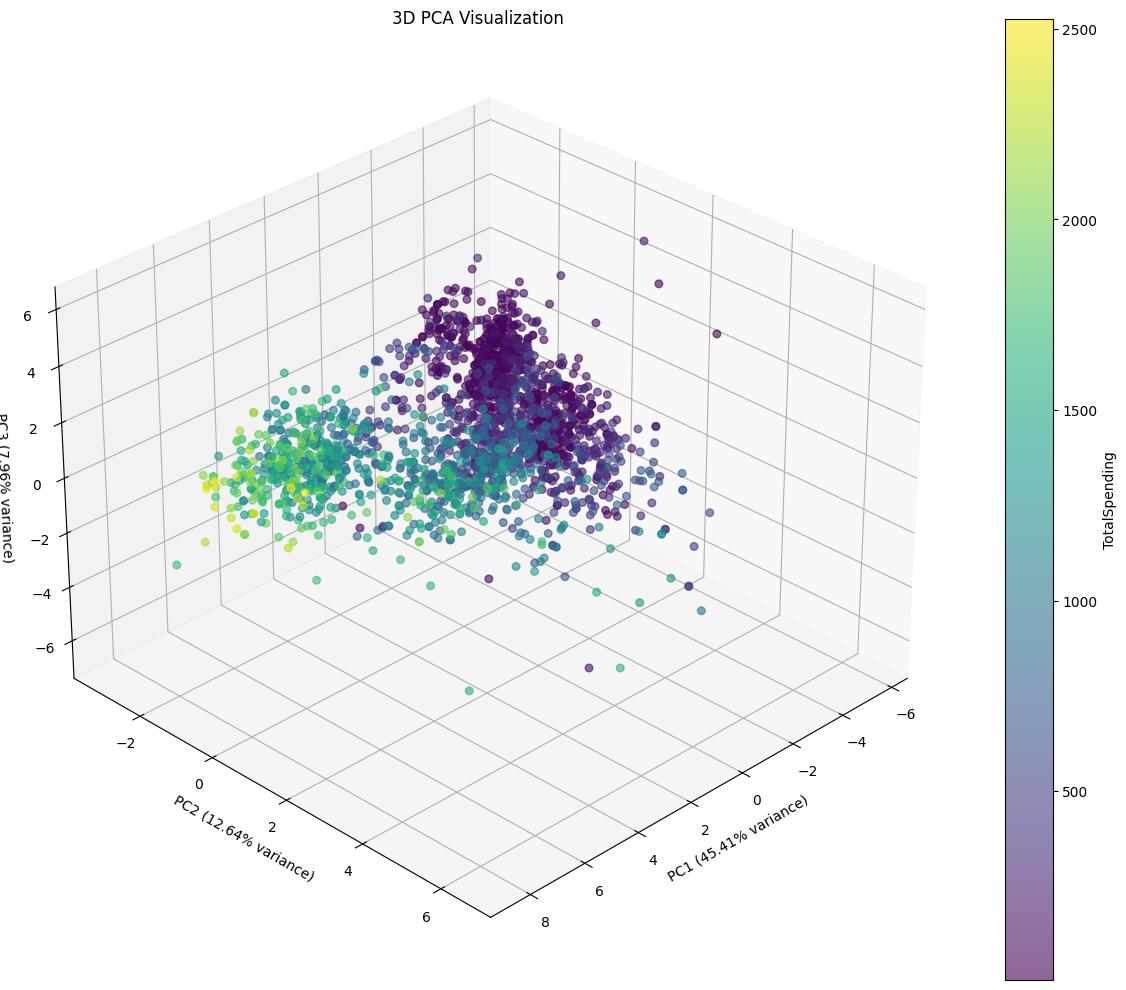

In [ ]:
# Create 3D visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with PC1, PC2, and PC3
scatter = ax.scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    df_pca['PC3'],
    c=df2['TotalSpending'],  # Color points by TotalSpending for added dimension
    cmap='viridis',
    alpha=0.6,
    s=30
)

# Add labels and title
ax.set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
ax.set_zlabel(f'PC3 ({explained_variance[2]:.2%} variance)')
ax.set_title('3D PCA Visualization')

# Add colorbar to show TotalSpending scale
cbar = plt.colorbar(scatter)
cbar.set_label('TotalSpending')

# Improve perspective
ax.view_init(elev=30, azim=45)  # Adjust viewing angle

# Show plot
plt.tight_layout()
plt.show()


# Clustering

After we have reduced dimensionality with PCA, we will cluster the data with K-Means and Apriori Algorithm with the following steps:

1. Use Elbow Method and Silhouette Score to determine the number of clusters
2. Use K-Means to cluster data
3. Use Apriori Algorithm to identify the highest buyers in each product category

### Elbow Method

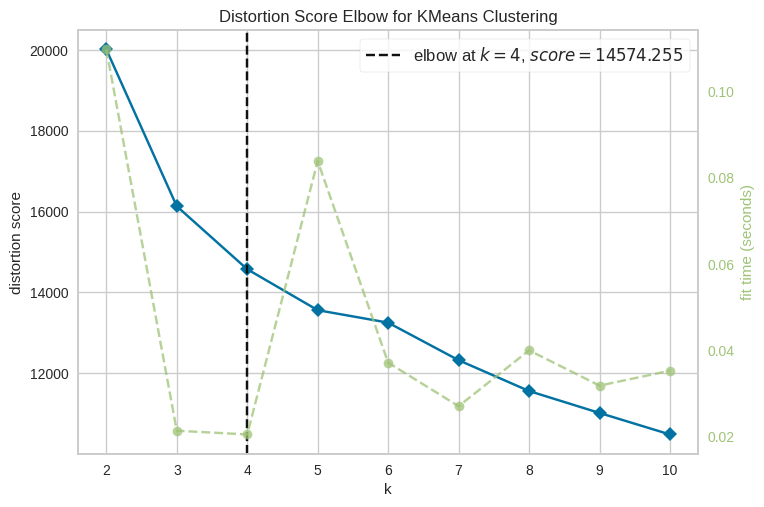

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Use Elbow Method to find the number of cluster, which is 4
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_pca)
Elbow_M.show()

### Silhouette Score

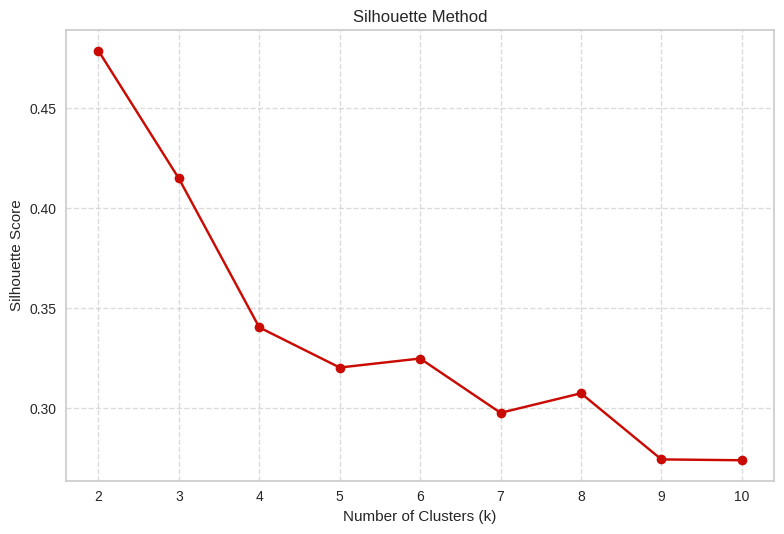

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(df_pca[['PC1', 'PC2', 'PC3']])

    # Calculate silhouette score
    if k > 1:  # Silhouette Score requires at least 2 clusters
        sil_score = silhouette_score(df_pca[['PC1', 'PC2', 'PC3']], kmeans_test.labels_)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(0)

# Silhouette score plot
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### K-Means

Silhouette Score with 4 clusters: 0.338


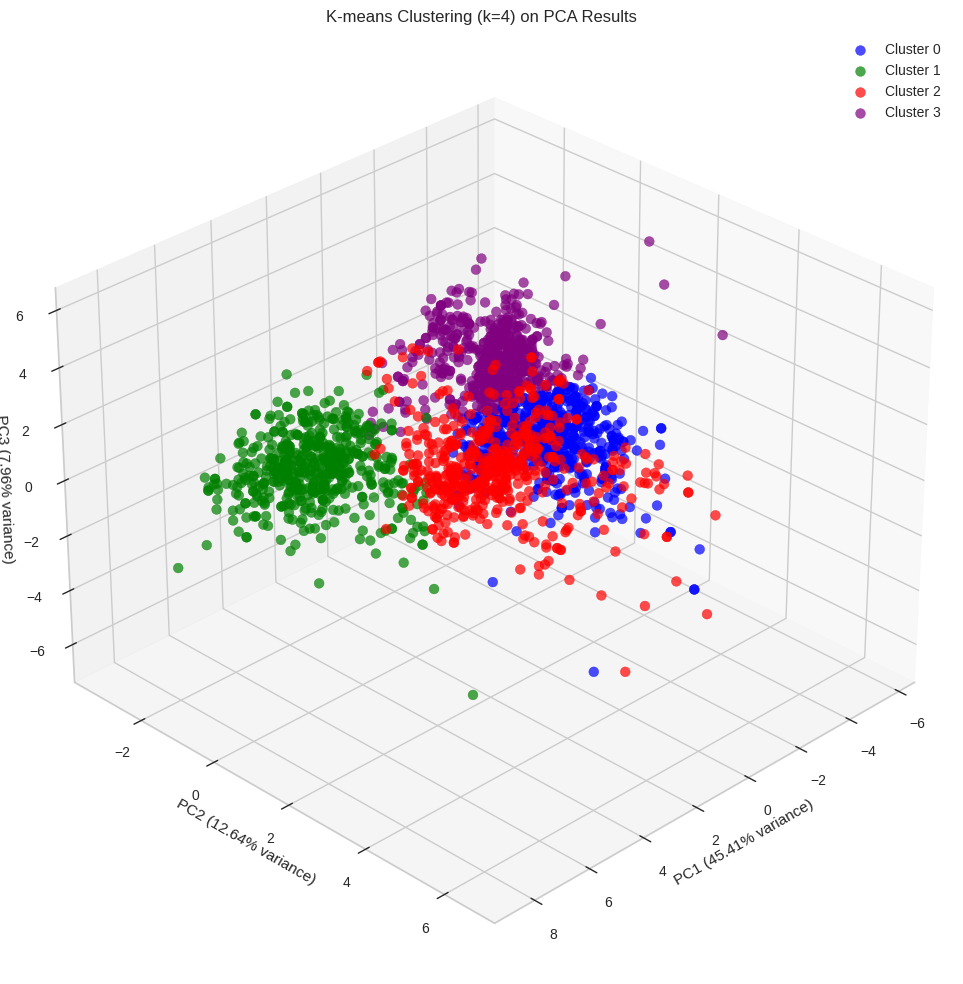

In [ ]:

# Apply K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_pca)

# Add cluster labels to the PCA DataFrame
df_pca['Cluster'] = clusters

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_pca[['PC1', 'PC2', 'PC3']], clusters)
print(f"Silhouette Score with 4 clusters: {silhouette_avg:.3f}")

# Visualize the clusters in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the clusters
colors = ['blue', 'green', 'red', 'purple']
cluster_labels = [0, 1, 2, 3]

# Plot each cluster with a different color
for cluster, color in zip(cluster_labels, colors):
    # Get points in this cluster
    cluster_points = df_pca[df_pca['Cluster'] == cluster]
    ax.scatter(
        cluster_points['PC1'],
        cluster_points['PC2'],
        cluster_points['PC3'],
        c=color,
        label=f'Cluster {cluster}',
        alpha=0.7,
        s=50
    )

# Add labels and title
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
ax.set_title('K-means Clustering (k=4) on PCA Results')

# Add legend
ax.legend()

# Improve perspective
ax.view_init(elev=30, azim=45)  # Adjust viewing angle

plt.tight_layout()
plt.show()

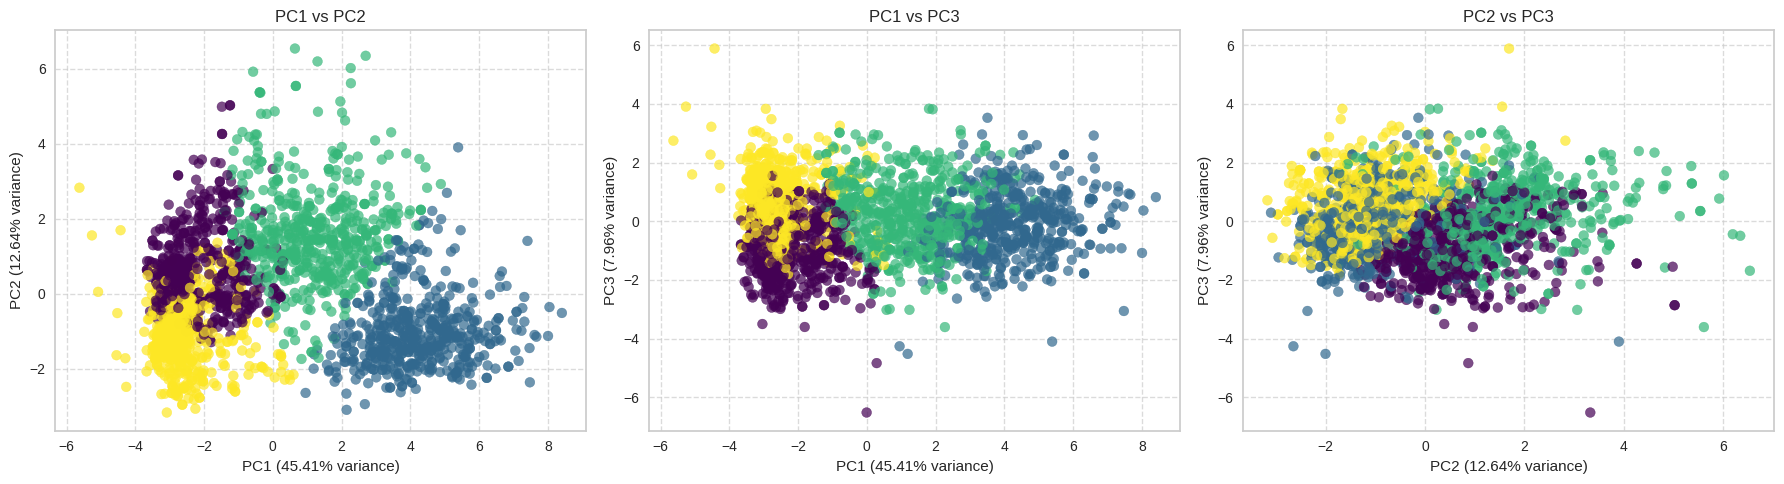

In [ ]:
# Create 2D visualizations of pairs of principal components
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PC1 vs PC2
axes[0].scatter(
    df_pca['PC1'],
    df_pca['PC2'],
    c=df_pca['Cluster'],
    cmap='viridis',
    alpha=0.7,
    s=50
)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('PC1 vs PC2')
axes[0].grid(True, linestyle='--', alpha=0.7)

# PC1 vs PC3
axes[1].scatter(
    df_pca['PC1'],
    df_pca['PC3'],
    c=df_pca['Cluster'],
    cmap='viridis',
    alpha=0.7,
    s=50
)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
axes[1].set_title('PC1 vs PC3')
axes[1].grid(True, linestyle='--', alpha=0.7)

# PC2 vs PC3
axes[2].scatter(
    df_pca['PC2'],
    df_pca['PC3'],
    c=df_pca['Cluster'],
    cmap='viridis',
    alpha=0.7,
    s=50
)
axes[2].set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
axes[2].set_title('PC2 vs PC3')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze cluster characteristics
# Add original features back to the PCA results for analysis
df_with_clusters = pd.concat([df2, df_pca[['Cluster']]], axis=1)

# Compute the average values of each feature by cluster
cluster_averages = df_with_clusters.groupby('Cluster').mean()

# Show the results
print("\nCluster Average Values:")
print(cluster_averages)


Cluster Average Values:
               Income     Recency    MntWines  MntFruits  MntMeatProducts  \
Cluster                                                                     
0        45643.890130  285.959032  100.137803   5.240223        35.031657   
1        77350.293774  348.603113  621.566148  66.394942       481.892996   
2        60815.035055  425.584871  526.824723  32.662362       168.394834   
3        29448.640747  354.009331   33.018663   6.390358        24.261275   

         MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
Cluster                                                                       
0               7.147114          4.955307     17.398510           2.726257   
1              99.871595         69.710117     75.420233           1.145914   
2              41.273063         32.998155     72.514760           3.632841   
3               9.936236          6.493002     17.004666           1.833593   

         NumWebPurchases  ...  TotalS

### K-Means Cluster Interpretation


#### **Cluster 0 – Low-Spending, Older Families**

* **Profile**: Moderate income (\~\$45K), older age (\~61), larger family size (\~2.8), all parents.
* **Spending**: Very low spending across all product categories ($170).
* **Behavior**: Average web/store purchases, but relatively high web visits.
* **Insight**: Possibly budget-conscious older families who browse often but spend little. Potential to convert with targeted promotions or better product-market fit.
* **Chracteristics**: Value-conscious consumers who occasionally shop but are particularly attracted to deals



#### **Cluster 1 – Very High-Income, High-Spending, Catalog-Driven Shoppers**

* **Profile**: Highest income (\~\$77K), slightly younger (\~57), smallest family size (\~1.1), highly educated.
* **Spending**: Extremely high across all product categories ($1,415) (esp. wines, meats, gold).
* **Behavior**: Heavy catalog/store buyers with fewer web visits and promotions used.
* **Insight**: Loyal, affluent customers—prime candidates for premium product launches or loyalty programs.
* **Characteristics**: Luxury-oriented consumers with disposable income who value premium products



#### **Cluster 2 – High-Income, Digitally Active Shoppers**

* **Profile**: High income (\~\$61K), average age (\~59), medium family size (\~2.1).
* **Spending**: High spending but less than Cluster 1 ($875), especially in wines and gold.
* **Behavior**: Highest web purchases, moderate store/catalog purchases.
* **Insight**: Digitally active and valuable—ideal for personalized online campaigns and cross-channel engagement.
* **Characteristics**: Digitally-savvy consumers with preference for wines who shop across multiple channels



#### **Cluster 3 – Young, Low-Income, Low-Spending**

* **Profile**: Youngest group (\~49), lowest income (\~29K), smaller family size, lower education.
* **Spending**: Lowest overall ($97), minimal engagement with any product category.
* **Behavior**: High web visits but few purchases.
* **Insight**: Price-sensitive browsers—may respond to discounts, bundles, or entry-level products.
* **Characteristics**: Budget-restricted consumers who browse frequently online but purchase infrequently




### Apriori Algorithm

Please Note: When viewing this suggest we suggest minimizing/maximizing each section as you go. Some of the Association tables are quite large.

In [ ]:
# May need to install mlxtend

#!pip install mlxtend


In [ ]:
#May need to install networkx

#!pip install networkx

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# Implements the Apriori Algothim using the mlxtend library
#
# All Product Interactions

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Product groups for Segmentation
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Establish Customer Spending segments within each, from low to high spedning in each category
for product in product_cols:
    df_with_clusters[f'{product}_Segment'] = pd.qcut(df_with_clusters[product], 4, labels=['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'])

# Apriori Algorithm for all products
# Prepare data for Apriori (one-hot encoding)
all_products_data = df_with_clusters[['Cluster'] + [f'{product}_Segment' for product in product_cols]]

# Convert 'Cluster' column to string type
all_products_data['Cluster'] = all_products_data['Cluster'].astype(str)

# One-hot encode 'Cluster' and product segments
all_products_data = pd.get_dummies(all_products_data, columns=['Cluster'] + [f'{product}_Segment' for product in product_cols],
                                   prefix=['Cluster'] + product_cols)

# Apply Apriori algorithm and create association rules to be analyzed
# Setting a low minimum support, this will be adjust below in filters
frequent_itemsets = apriori(all_products_data, min_support=0.05, use_colnames=True) # Adjust min_support as needed
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Print All association rules for overview/initial look, will filter these later and narrow search
print("\nAssociation Rules:")

# rules may be very long, uncomment to see
#rules



Association Rules:


<ipython-input-53-09ce40d80921>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_products_data['Cluster'] = all_products_data['Cluster'].astype(str)


In [ ]:
# Apply some filters to narrow down the initial association rule, and sort by lift and confidence to see the most reliable associations first

#not applying any filters for first look, just high minimum support
filter_groups = []  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'
min_support = 0.15

filtered_rules = rules[rules['support'] >= min_support]  # Filter by minimum support
sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 38


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
32,(MntMeatProducts_biggest-buyer),(Cluster_1),0.249106,0.229875,0.193649,0.777379,3.381749,1.0,0.136386,3.459353,0.937941,0.678683,0.710929,0.809896
33,(Cluster_1),(MntMeatProducts_biggest-buyer),0.229875,0.249106,0.193649,0.842412,3.381749,1.0,0.136386,4.764935,0.914520,0.678683,0.790134,0.809896
94,(MntWines_non-buyer),(MntMeatProducts_non-buyer),0.254472,0.263864,0.193649,0.760984,2.884001,1.0,0.126503,3.079863,0.876238,0.596419,0.675310,0.747441
95,(MntMeatProducts_non-buyer),(MntWines_non-buyer),0.263864,0.254472,0.193649,0.733898,2.884001,1.0,0.126503,2.801665,0.887417,0.596419,0.643069,0.747441
296,(MntFishProducts_biggest-buyer),(MntSweetProducts_biggest-buyer),0.245528,0.249553,0.174419,0.710383,2.846622,1.0,0.113146,2.591167,0.859815,0.543933,0.614073,0.704654
297,(MntSweetProducts_biggest-buyer),(MntFishProducts_biggest-buyer),0.249553,0.245528,0.174419,0.698925,2.846622,1.0,0.113146,2.505926,0.864427,0.543933,0.600946,0.704654
37,(Cluster_1),(MntFishProducts_biggest-buyer),0.229875,0.245528,0.159660,0.694553,2.828815,1.0,0.103219,2.470056,0.839467,0.505666,0.595151,0.672413
36,(MntFishProducts_biggest-buyer),(Cluster_1),0.245528,0.229875,0.159660,0.650273,2.828815,1.0,0.103219,2.202077,0.856884,0.505666,0.545883,0.672413
216,(MntFruits_biggest-buyer),(MntSweetProducts_biggest-buyer),0.245975,0.249553,0.169052,0.687273,2.754018,1.0,0.107668,2.399686,0.844659,0.517808,0.583279,0.682346
217,(MntSweetProducts_biggest-buyer),(MntFruits_biggest-buyer),0.249553,0.245975,0.169052,0.677419,2.754018,1.0,0.107668,2.337478,0.848686,0.517808,0.572188,0.682346


In [ ]:
# Narrow down even further by increasing min_support

filter_groups = []  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'
min_support = 0.172
filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x)))  # Antecedent filter using substrings
]

sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 10


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
32,(MntMeatProducts_biggest-buyer),(Cluster_1),0.249106,0.229875,0.193649,0.777379,3.381749,1.0,0.136386,3.459353,0.937941,0.678683,0.710929,0.809896
33,(Cluster_1),(MntMeatProducts_biggest-buyer),0.229875,0.249106,0.193649,0.842412,3.381749,1.0,0.136386,4.764935,0.914520,0.678683,0.790134,0.809896
94,(MntWines_non-buyer),(MntMeatProducts_non-buyer),0.254472,0.263864,0.193649,0.760984,2.884001,1.0,0.126503,3.079863,0.876238,0.596419,0.675310,0.747441
95,(MntMeatProducts_non-buyer),(MntWines_non-buyer),0.263864,0.254472,0.193649,0.733898,2.884001,1.0,0.126503,2.801665,0.887417,0.596419,0.643069,0.747441
296,(MntFishProducts_biggest-buyer),(MntSweetProducts_biggest-buyer),0.245528,0.249553,0.174419,0.710383,2.846622,1.0,0.113146,2.591167,0.859815,0.543933,0.614073,0.704654
297,(MntSweetProducts_biggest-buyer),(MntFishProducts_biggest-buyer),0.249553,0.245528,0.174419,0.698925,2.846622,1.0,0.113146,2.505926,0.864427,0.543933,0.600946,0.704654
67,(MntWines_non-buyer),(Cluster_3),0.254472,0.287567,0.187835,0.738137,2.566834,1.0,0.114658,2.720633,0.818769,0.530303,0.632438,0.695663
66,(Cluster_3),(MntWines_non-buyer),0.287567,0.254472,0.187835,0.653188,2.566834,1.0,0.114658,2.149661,0.856804,0.530303,0.534810,0.695663
223,(MntMeatProducts_non-buyer),(MntFishProducts_non-buyer),0.263864,0.304114,0.175313,0.664407,2.184726,1.0,0.095068,2.073598,0.736653,0.446469,0.517747,0.620439
222,(MntFishProducts_non-buyer),(MntMeatProducts_non-buyer),0.304114,0.263864,0.175313,0.576471,2.184726,1.0,0.095068,1.738099,0.779261,0.446469,0.424659,0.620439


<ipython-input-56-f272ad5cd930>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


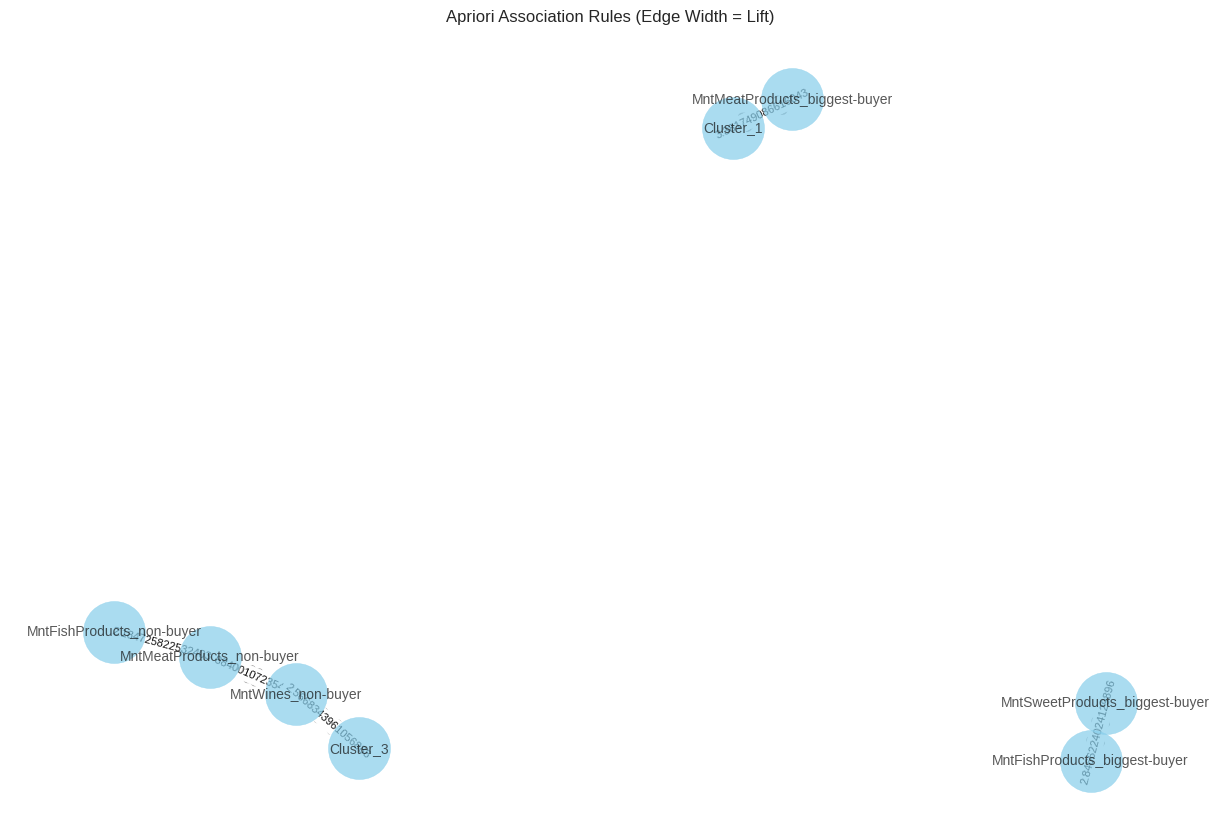

In [ ]:
# Viusalist the Top Assoications From the Dataset

# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges with lift as weight
for index, row in sorted_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for antecedent in antecedents:
        graph.add_node(antecedent)
    for consequent in consequents:
        graph.add_node(consequent)

    # Add edges for the association rules, using lift as weight
    for antecedent in antecedents:
        for consequent in consequents:
            graph.add_edge(antecedent, consequent, weight=row['lift'])

# Set node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=50)

# Get edge weights (lift values) for setting edge widths
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# Scale edge weights to a suitable range for visualization
edge_widths = [w * 2 for w in edge_weights]  # Adjust the scaling factor as needed

# Draw the graph with edge widths based on lift
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10,
        edge_color="gray", arrowsize=20, width=edge_widths, alpha=0.7)  # Set width using edge_widths

# Add edge labels for lift values (optional)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Apriori Association Rules (Edge Width = Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()

#### **Overall Customer Segment Insights:** Filtering Interactions for Cluster Anticedents, and Significant Interactions

In [ ]:
# Filter Purchase amount segments out of antecedents, to isolate customer segments/clusters in the "if" of apriori. To say if a customer is from 'customer segment x' (antecedents) then 'they are likely buy y' (consequents)
# Since we are interested in discovering how to market to different customer segments, we're filting out the purchase segments

filter_groups = ['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'
min_support = 0.1
filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x)))  # Antecedent filter using substrings
]

sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)


Number of results after filter is: 32


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1670,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntFishProduct...",0.229875,0.122540,0.101968,0.443580,3.619870,1.0,0.073799,1.576973,0.939778,0.407143,0.365874,0.637848
509,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntFishProduct...",0.229875,0.165921,0.137746,0.599222,3.611482,1.0,0.099605,2.081148,0.938945,0.533795,0.519496,0.714705
455,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntWines_bigge...",0.229875,0.145796,0.116726,0.507782,3.482824,1.0,0.083211,1.735418,0.925663,0.450777,0.423770,0.654198
514,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntSweetProduc...",0.229875,0.165474,0.131932,0.573930,3.468398,1.0,0.093894,1.958659,0.924113,0.500849,0.489447,0.685614
484,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntFruits_bigg...",0.229875,0.156530,0.124329,0.540856,3.455297,1.0,0.088347,1.837050,0.922693,0.474403,0.455649,0.667571
33,(Cluster_1),(MntMeatProducts_biggest-buyer),0.229875,0.249106,0.193649,0.842412,3.381749,1.0,0.136386,4.764935,0.914520,0.678683,0.790134,0.809896
532,(Cluster_1),"(MntFishProducts_biggest-buyer, MntSweetProduc...",0.229875,0.174419,0.119857,0.521401,2.989364,1.0,0.079762,1.724995,0.864120,0.421384,0.420288,0.604290
490,(Cluster_1),"(MntFishProducts_biggest-buyer, MntFruits_bigg...",0.229875,0.164580,0.108676,0.472763,2.872547,1.0,0.070844,1.584524,0.846456,0.380282,0.368896,0.566544
495,(Cluster_1),"(MntFruits_biggest-buyer, MntSweetProducts_big...",0.229875,0.169052,0.110912,0.482490,2.854096,1.0,0.072052,1.605667,0.843533,0.385093,0.377206,0.569287
37,(Cluster_1),(MntFishProducts_biggest-buyer),0.229875,0.245528,0.159660,0.694553,2.828815,1.0,0.103219,2.470056,0.839467,0.505666,0.595151,0.672413


<ipython-input-58-f272ad5cd930>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


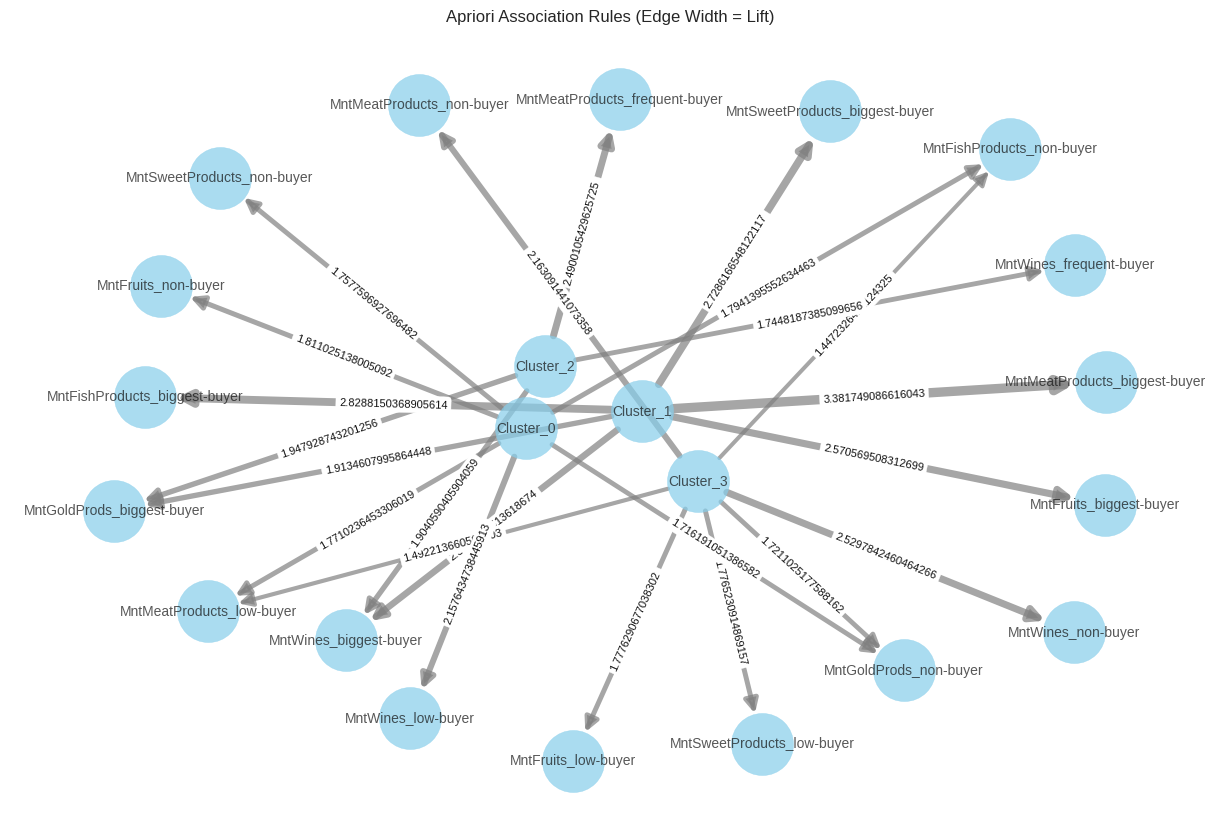

In [ ]:
# Visualize the Top Assoications From the Dataset

# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges with lift as weight
for index, row in sorted_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for antecedent in antecedents:
        graph.add_node(antecedent)
    for consequent in consequents:
        graph.add_node(consequent)

    # Add edges for the association rules, using lift as weight
    for antecedent in antecedents:
        for consequent in consequents:
            graph.add_edge(antecedent, consequent, weight=row['lift'])

# Set node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=50)

# Get edge weights (lift values) for setting edge widths
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# Scale edge weights to a suitable range for visualization
edge_widths = [w * 2 for w in edge_weights]  # Adjust the scaling factor as needed

# Draw the graph with edge widths based on lift
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10,
        edge_color="gray", arrowsize=20, width=edge_widths, alpha=0.7)  # Set width using edge_widths

# Add edge labels for lift values (optional)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Apriori Association Rules (Edge Width = Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()

<ipython-input-59-763d5d0c8299>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(sorted_rules, x='confidence', y='antecedents', inner='stick', palette='Dark2')


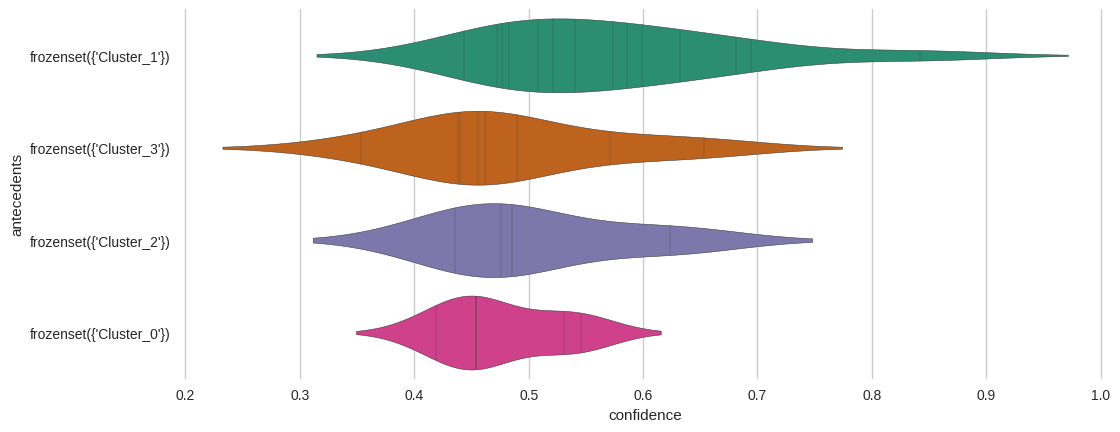

In [ ]:
# @title Cluster Antecedents vs Confidence

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(sorted_rules['antecedents'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(sorted_rules, x='confidence', y='antecedents', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#### **Customer Segment 0 Insights:** Filtering Interactions for Cluster Anticedents, and Significant Interactions

In [ ]:
# Filter Purchase amount segments out of antecedents, and most clusters to isolate a single cluster. To say if a customer is from 'customer segment x' (antecedents) then 'they are likely buy y' (consequents)
# Because Customer segment/cluster 1 dominates the higher scoring associations when looking at all clusters together, we need to isolated clusters to better understand insights for thost specific customer segments
# Since we are interested in discovering how to market to different customer segments, we're filting out the purchase segments

#isolating cluster_0
filter_groups = ['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer', 'Cluster_1', 'Cluster_2', 'Cluster_3']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'... 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'
min_support = 0.1
filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x)))  # Antecedent filter using substrings
]

sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 6


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,(Cluster_0),(MntWines_low-buyer),0.240161,0.245975,0.127460,0.530726,2.157643,1.0,0.068386,1.606791,0.706112,0.355362,0.377642,0.524454
4,(Cluster_0),(MntFruits_non-buyer),0.240161,0.250894,0.109123,0.454376,1.811025,1.0,0.048868,1.372934,0.589370,0.285714,0.271633,0.444657
12,(Cluster_0),(MntFishProducts_non-buyer),0.240161,0.304114,0.131038,0.545624,1.794140,1.0,0.058001,1.531519,0.582531,0.317100,0.347053,0.488253
10,(Cluster_0),(MntMeatProducts_low-buyer),0.240161,0.236583,0.100626,0.418994,1.771024,1.0,0.043808,1.313958,0.572957,0.267539,0.238941,0.422163
16,(Cluster_0),(MntSweetProducts_non-buyer),0.240161,0.258497,0.109123,0.454376,1.757760,1.0,0.047042,1.359000,0.567349,0.280138,0.264165,0.438261
21,(Cluster_0),(MntGoldProds_non-buyer),0.240161,0.264758,0.109123,0.454376,1.716191,1.0,0.045539,1.347525,0.549214,0.275706,0.257898,0.433269


In [ ]:
#isolating cluster_0
# Reducing the min-support threshold to look for multiple product associations

filter_groups = ['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer', 'Cluster_1', 'Cluster_2', 'Cluster_3']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'... 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'
filter_groups_consequents = ['non-buyer']
min_support = 0.05

filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x))) &  # Antecedent filter using substrings
    (~rules['consequents'].apply(lambda x: any(any(group in item for group in filter_groups_consequents) for item in x)))
]

sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 8


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
334,(Cluster_0),"(MntWines_low-buyer, MntMeatProducts_low-buyer)",0.240161,0.110912,0.058140,0.242086,2.182676,1.0,0.031503,1.173071,0.713107,0.198473,0.147537,0.383140
3,(Cluster_0),(MntWines_low-buyer),0.240161,0.245975,0.127460,0.530726,2.157643,1.0,0.068386,1.606791,0.706112,0.355362,0.377642,0.524454
382,(Cluster_0),"(MntFruits_low-buyer, MntMeatProducts_low-buyer)",0.240161,0.113596,0.050537,0.210428,1.852432,1.0,0.023255,1.122639,0.605614,0.166667,0.109242,0.327655
10,(Cluster_0),(MntMeatProducts_low-buyer),0.240161,0.236583,0.100626,0.418994,1.771024,1.0,0.043808,1.313958,0.572957,0.267539,0.238941,0.422163
18,(Cluster_0),(MntSweetProducts_low-buyer),0.240161,0.246869,0.084079,0.350093,1.418131,1.0,0.024790,1.158828,0.388038,0.208657,0.137059,0.345336
14,(Cluster_0),(MntFishProducts_low-buyer),0.240161,0.205725,0.068873,0.286778,1.393992,1.0,0.019466,1.113645,0.371968,0.182681,0.102048,0.310781
7,(Cluster_0),(MntFruits_low-buyer),0.240161,0.259839,0.086315,0.359404,1.383180,1.0,0.023912,1.155426,0.364588,0.208649,0.134518,0.345795
22,(Cluster_0),(MntGoldProds_low-buyer),0.240161,0.237030,0.070662,0.294227,1.241306,1.0,0.013736,1.081041,0.255839,0.173817,0.074966,0.296170


<ipython-input-62-f272ad5cd930>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


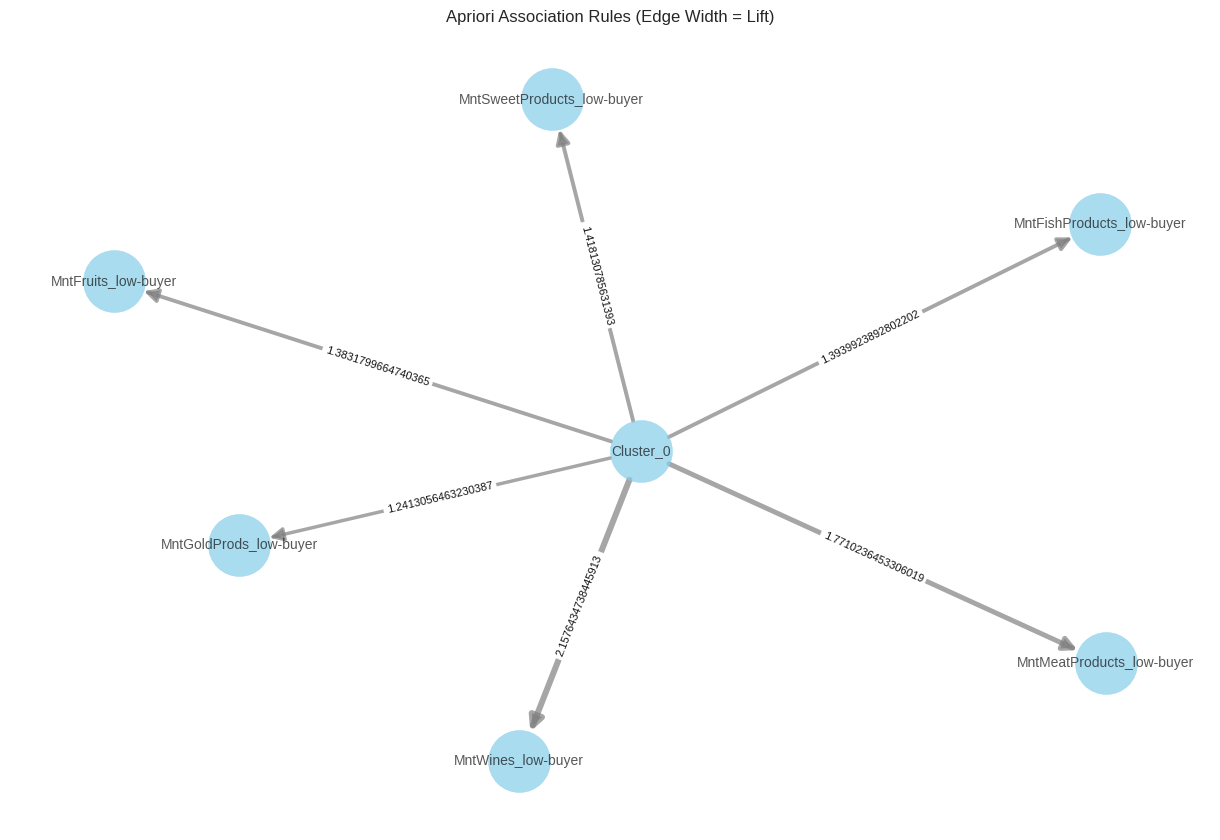

In [ ]:
# Viusalist the Top Assoications From the Dataset

# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges with lift as weight
for index, row in sorted_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for antecedent in antecedents:
        graph.add_node(antecedent)
    for consequent in consequents:
        graph.add_node(consequent)

    # Add edges for the association rules, using lift as weight
    for antecedent in antecedents:
        for consequent in consequents:
            graph.add_edge(antecedent, consequent, weight=row['lift'])

# Set node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=50)

# Get edge weights (lift values) for setting edge widths
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# Scale edge weights to a suitable range for visualization
edge_widths = [w * 2 for w in edge_weights]  # Adjust the scaling factor as needed

# Draw the graph with edge widths based on lift
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10,
        edge_color="gray", arrowsize=20, width=edge_widths, alpha=0.7)  # Set width using edge_widths

# Add edge labels for lift values (optional)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Apriori Association Rules (Edge Width = Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()

#### **Customer Segment 1 Insights:** Filtering Interactions for Cluster Anticedents, and Significant Interactions

In [ ]:
# Filter Purchase amount segments out of antecedents, and most clusters to isolate a single cluster. To say if a customer is from 'customer segment x' (antecedents) then 'they are likely buy y' (consequents)
# Because Customer segment/cluster 1 dominates the higher scoring associations when looking at all clusters together, we need to isolated clusters to better understand insights for thost specific customer segments
# Since we are interested in discovering how to market to different customer segments, we're filting out the purchase segments

#isolatiing cluster_1
filter_groups = ['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer', 'Cluster_0', 'Cluster_2', 'Cluster_3']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'... 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'
min_support = 0.1
filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x)))  # Antecedent filter using substrings
]
sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 14


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1670,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntFishProduct...",0.229875,0.122540,0.101968,0.443580,3.619870,1.0,0.073799,1.576973,0.939778,0.407143,0.365874,0.637848
509,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntFishProduct...",0.229875,0.165921,0.137746,0.599222,3.611482,1.0,0.099605,2.081148,0.938945,0.533795,0.519496,0.714705
455,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntWines_bigge...",0.229875,0.145796,0.116726,0.507782,3.482824,1.0,0.083211,1.735418,0.925663,0.450777,0.423770,0.654198
514,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntSweetProduc...",0.229875,0.165474,0.131932,0.573930,3.468398,1.0,0.093894,1.958659,0.924113,0.500849,0.489447,0.685614
484,(Cluster_1),"(MntMeatProducts_biggest-buyer, MntFruits_bigg...",0.229875,0.156530,0.124329,0.540856,3.455297,1.0,0.088347,1.837050,0.922693,0.474403,0.455649,0.667571
33,(Cluster_1),(MntMeatProducts_biggest-buyer),0.229875,0.249106,0.193649,0.842412,3.381749,1.0,0.136386,4.764935,0.914520,0.678683,0.790134,0.809896
532,(Cluster_1),"(MntFishProducts_biggest-buyer, MntSweetProduc...",0.229875,0.174419,0.119857,0.521401,2.989364,1.0,0.079762,1.724995,0.864120,0.421384,0.420288,0.604290
490,(Cluster_1),"(MntFishProducts_biggest-buyer, MntFruits_bigg...",0.229875,0.164580,0.108676,0.472763,2.872547,1.0,0.070844,1.584524,0.846456,0.380282,0.368896,0.566544
495,(Cluster_1),"(MntFruits_biggest-buyer, MntSweetProducts_big...",0.229875,0.169052,0.110912,0.482490,2.854096,1.0,0.072052,1.605667,0.843533,0.385093,0.377206,0.569287
37,(Cluster_1),(MntFishProducts_biggest-buyer),0.229875,0.245528,0.159660,0.694553,2.828815,1.0,0.103219,2.470056,0.839467,0.505666,0.595151,0.672413


<ipython-input-64-f272ad5cd930>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


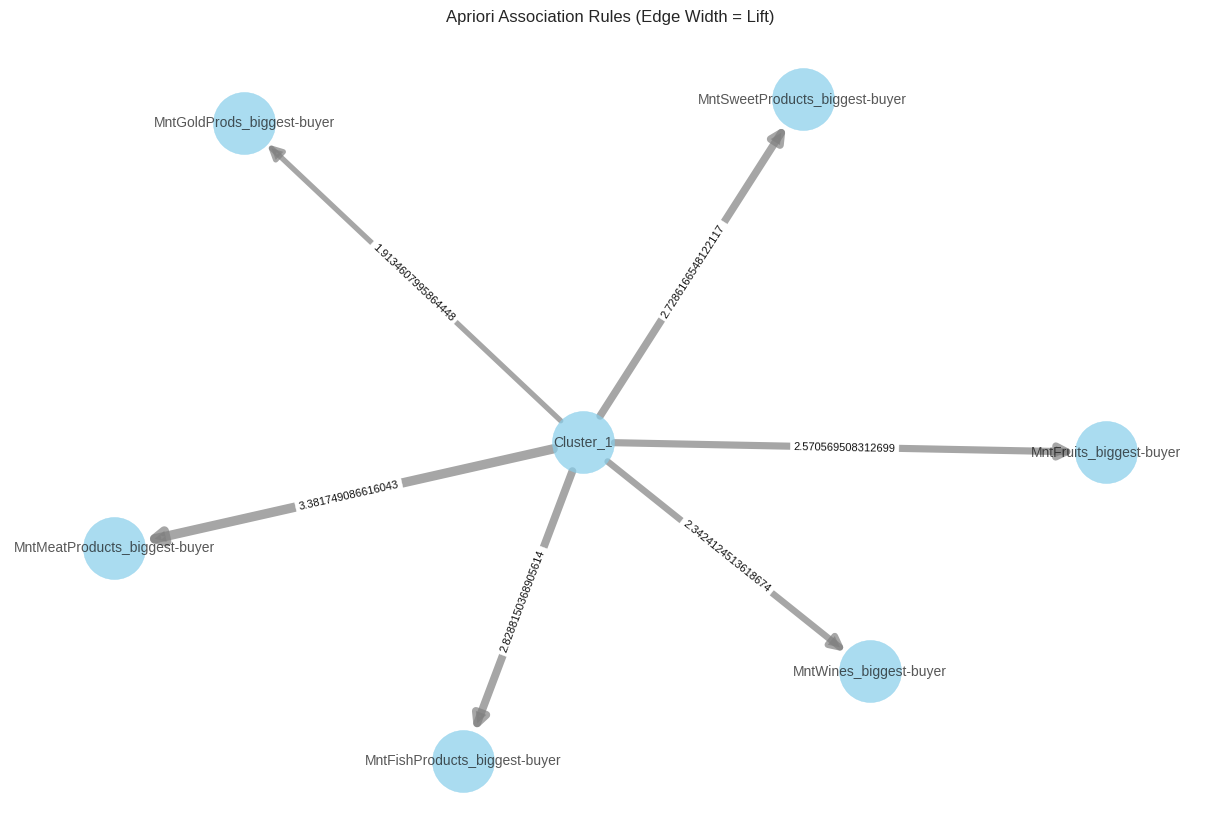

In [ ]:
# Visualize the Top Assoications From the Dataset

# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges with lift as weight
for index, row in sorted_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for antecedent in antecedents:
        graph.add_node(antecedent)
    for consequent in consequents:
        graph.add_node(consequent)

    # Add edges for the association rules, using lift as weight
    for antecedent in antecedents:
        for consequent in consequents:
            graph.add_edge(antecedent, consequent, weight=row['lift'])

# Set node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=50)

# Get edge weights (lift values) for setting edge widths
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# Scale edge weights to a suitable range for visualization
edge_widths = [w * 2 for w in edge_weights]  # Adjust the scaling factor as needed

# Draw the graph with edge widths based on lift
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10,
        edge_color="gray", arrowsize=20, width=edge_widths, alpha=0.7)  # Set width using edge_widths

# Add edge labels for lift values (optional)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Apriori Association Rules (Edge Width = Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()

#### **Customer Segment 2 Insights:** Filtering Interactions for Cluster Anticedents, and Significant Interactions

In [ ]:
# Filter Purchase amount segments out of antecedents, and most clusters to isolate a single cluster. To say if a customer is from 'customer segment x' (antecedents) then 'they are likely buy y' (consequents)
# Because Customer segment/cluster 1 dominates the higher scoring associations when looking at all clusters together, we need to isolated clusters to better understand insights for thost specific customer segments
# Since we are interested in discovering how to market to different customer segments, we're filting out the purchase segments

#isolating cluster_2

filter_groups = ['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer', 'Cluster_0', 'Cluster_1', 'Cluster_3']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'... 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'
min_support = 0.1
filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x)))  # Antecedent filter using substrings
]
sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 4


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
53,(Cluster_2),(MntMeatProducts_frequent-buyer),0.242397,0.250447,0.151163,0.623616,2.490011,1.0,0.090455,1.991459,0.789854,0.442408,0.497856,0.613594
64,(Cluster_2),(MntGoldProds_biggest-buyer),0.242397,0.249106,0.117621,0.485240,1.947929,1.0,0.057238,1.458727,0.642334,0.314593,0.314471,0.478706
46,(Cluster_2),(MntWines_biggest-buyer),0.242397,0.250000,0.115385,0.476015,1.904059,1.0,0.054785,1.431338,0.626722,0.306050,0.301353,0.468777
44,(Cluster_2),(MntWines_frequent-buyer),0.242397,0.249553,0.105546,0.435424,1.744819,1.0,0.045055,1.329224,0.563454,0.273148,0.247681,0.429182


<ipython-input-66-f272ad5cd930>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


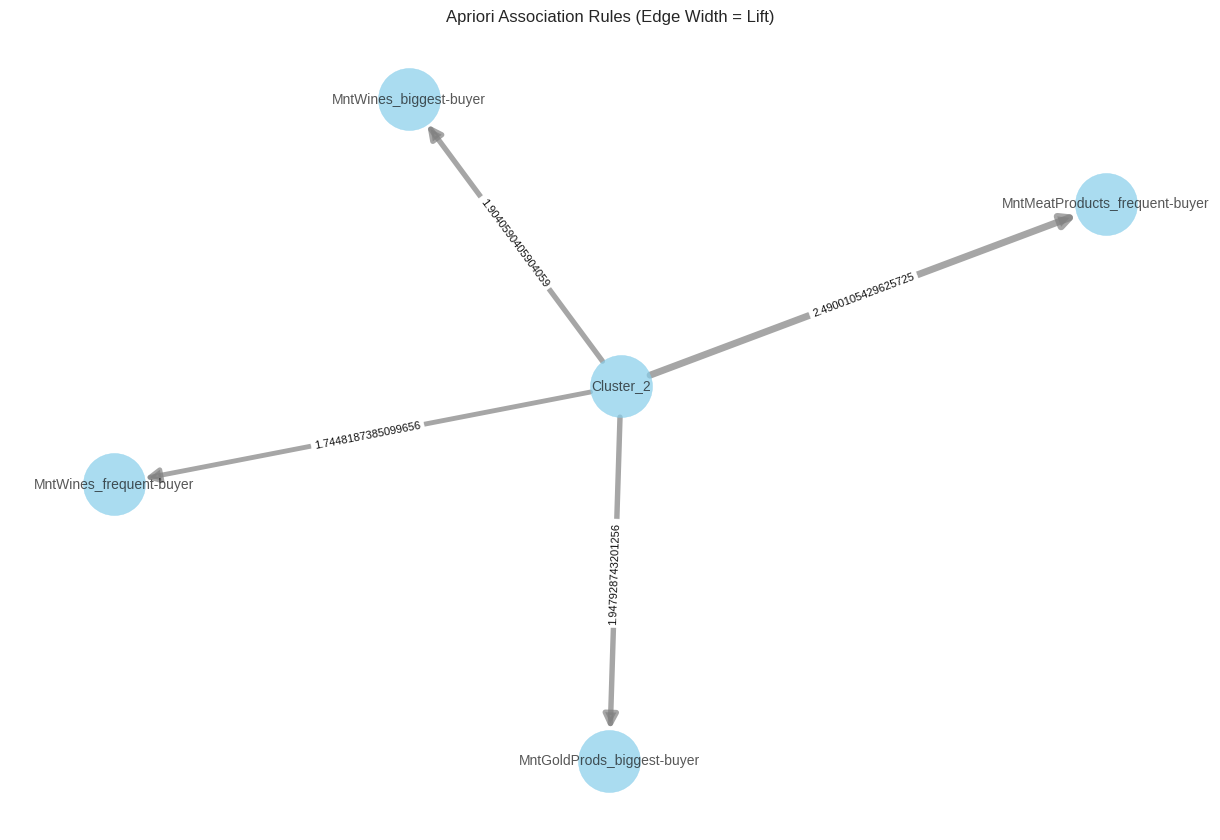

In [ ]:
# Visualize the Top Assoications From the Dataset

# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges with lift as weight
for index, row in sorted_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for antecedent in antecedents:
        graph.add_node(antecedent)
    for consequent in consequents:
        graph.add_node(consequent)

    # Add edges for the association rules, using lift as weight
    for antecedent in antecedents:
        for consequent in consequents:
            graph.add_edge(antecedent, consequent, weight=row['lift'])

# Set node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=50)

# Get edge weights (lift values) for setting edge widths
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# Scale edge weights to a suitable range for visualization
edge_widths = [w * 2 for w in edge_weights]  # Adjust the scaling factor as needed

# Draw the graph with edge widths based on lift
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10,
        edge_color="gray", arrowsize=20, width=edge_widths, alpha=0.7)  # Set width using edge_widths

# Add edge labels for lift values (optional)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Apriori Association Rules (Edge Width = Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()

#### **Customer Segment 3 Insights:** Filtering Interactions for Cluster Anticedents, and Significant Interactions

In [ ]:
# Filter Purchase amount segments out of antecedents, and most clusters to isolate a single cluster. To say if a customer is from 'customer segment x' (antecedents) then 'they are likely buy y' (consequents)
# Because Customer segment/cluster 1 dominates the higher scoring associations when looking at all clusters together, we need to isolated clusters to better understand insights for thost specific customer segments
# Since we are interested in discovering how to market to different customer segments, we're filting out the purchase segments

#isolating cluster_3
filter_groups = ['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer', 'Cluster_1', 'Cluster_2', 'Cluster_0']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'... 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'
min_support = 0.1
filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x)))  # Antecedent filter using substrings
]

sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 8


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
66,(Cluster_3),(MntWines_non-buyer),0.287567,0.254472,0.187835,0.653188,2.566834,1.0,0.114658,2.149661,0.856804,0.530303,0.534810,0.695663
645,(Cluster_3),"(MntWines_non-buyer, MntMeatProducts_non-buyer)",0.287567,0.193649,0.140877,0.489891,2.529784,1.0,0.085189,1.580742,0.848795,0.413929,0.367386,0.608687
74,(Cluster_3),(MntMeatProducts_non-buyer),0.287567,0.263864,0.164132,0.570762,2.163091,1.0,0.088254,1.714983,0.754736,0.423788,0.416904,0.596398
72,(Cluster_3),(MntFruits_low-buyer),0.287567,0.259839,0.132826,0.461897,1.777629,1.0,0.058105,1.375502,0.614027,0.320388,0.272992,0.486542
84,(Cluster_3),(MntSweetProducts_low-buyer),0.287567,0.246869,0.126118,0.438569,1.776523,1.0,0.055127,1.341449,0.613535,0.308872,0.254537,0.474719
86,(Cluster_3),(MntGoldProds_non-buyer),0.287567,0.264758,0.131038,0.455677,1.721103,1.0,0.054902,1.350744,0.588093,0.311040,0.259667,0.475304
76,(Cluster_3),(MntMeatProducts_low-buyer),0.287567,0.236583,0.101521,0.353033,1.492214,1.0,0.033487,1.179993,0.462998,0.240212,0.152537,0.391072
78,(Cluster_3),(MntFishProducts_non-buyer),0.287567,0.304114,0.126565,0.440124,1.447233,1.0,0.039112,1.242929,0.433762,0.272115,0.195449,0.428150


In [ ]:
#isolating cluster_3

filter_groups = ['non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer', 'Cluster_1', 'Cluster_2', 'Cluster_0']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'... 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'
filter_groups_consequents = ['non-buyer']
min_support = 0.05

filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x))) &  # Antecedent filter using substrings
    (~rules['consequents'].apply(lambda x: any(any(group in item for group in filter_groups_consequents) for item in x)))
]

sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 13


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
747,(Cluster_3),"(MntFruits_low-buyer, MntGoldProds_low-buyer)",0.287567,0.095707,0.057245,0.199067,2.079970,1.0,0.029723,1.129050,0.728804,0.175583,0.114299,0.398599
819,(Cluster_3),"(MntSweetProducts_low-buyer, MntGoldProds_low-...",0.287567,0.095259,0.055903,0.194401,2.040757,1.0,0.028510,1.123066,0.715837,0.170999,0.109580,0.390628
735,(Cluster_3),"(MntFruits_low-buyer, MntSweetProducts_low-buyer)",0.287567,0.138640,0.076476,0.265941,1.918206,1.0,0.036607,1.173420,0.671894,0.218670,0.147790,0.408777
801,(Cluster_3),"(MntSweetProducts_low-buyer, MntFishProducts_l...",0.287567,0.112254,0.058140,0.202177,1.801069,1.0,0.025859,1.112711,0.624303,0.170157,0.101294,0.360053
729,(Cluster_3),"(MntFruits_low-buyer, MntFishProducts_low-buyer)",0.287567,0.116279,0.059481,0.206843,1.778849,1.0,0.026043,1.114181,0.614568,0.172727,0.102480,0.359191
72,(Cluster_3),(MntFruits_low-buyer),0.287567,0.259839,0.132826,0.461897,1.777629,1.0,0.058105,1.375502,0.614027,0.320388,0.272992,0.486542
84,(Cluster_3),(MntSweetProducts_low-buyer),0.287567,0.246869,0.126118,0.438569,1.776523,1.0,0.055127,1.341449,0.613535,0.308872,0.254537,0.474719
687,(Cluster_3),"(MntWines_low-buyer, MntMeatProducts_low-buyer)",0.287567,0.110912,0.051431,0.178849,1.612527,1.0,0.019536,1.082734,0.533180,0.148196,0.076412,0.321279
80,(Cluster_3),(MntFishProducts_low-buyer),0.287567,0.205725,0.092576,0.321928,1.564852,1.0,0.033416,1.171374,0.506661,0.231027,0.146302,0.385964
723,(Cluster_3),"(MntFruits_low-buyer, MntMeatProducts_low-buyer)",0.287567,0.113596,0.050984,0.177294,1.560745,1.0,0.018318,1.077425,0.504301,0.145594,0.071861,0.313056


<ipython-input-69-f272ad5cd930>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


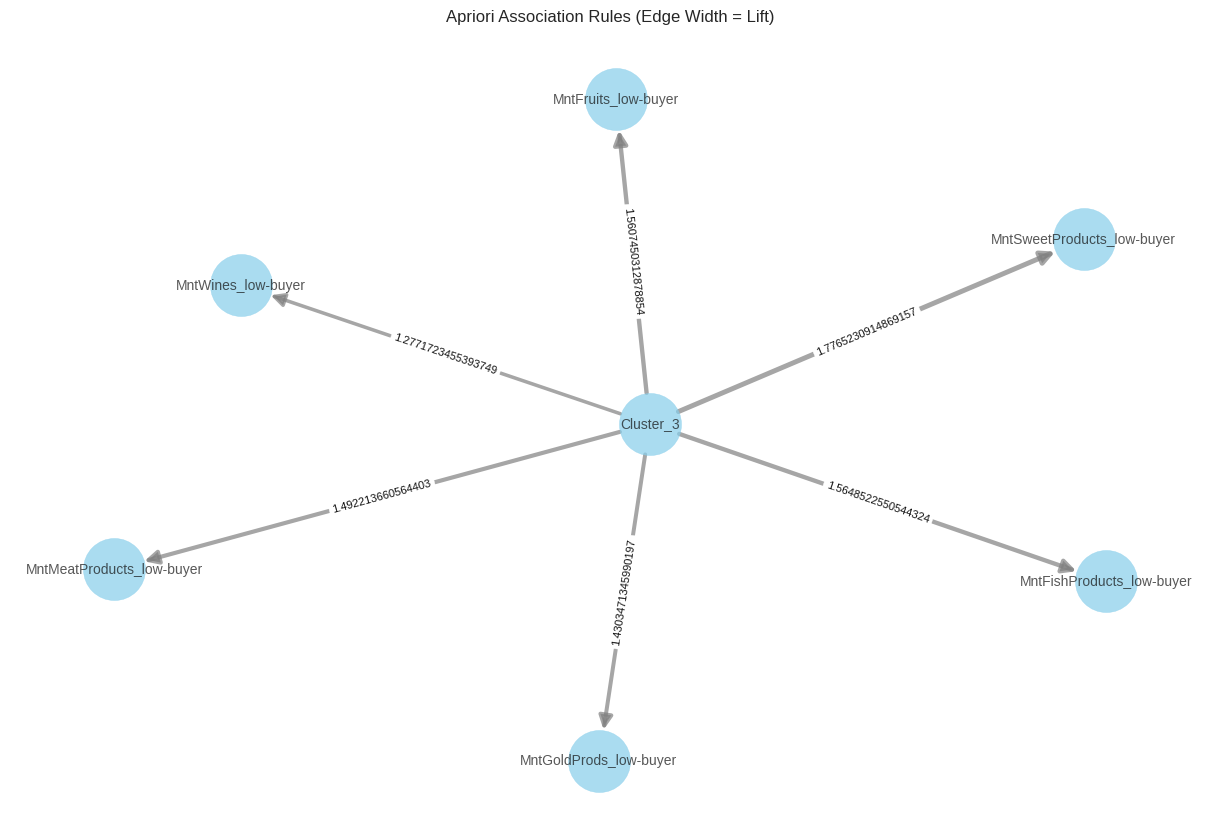

In [ ]:
# Viusalist the Top Assoications From the Dataset

# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges with lift as weight
for index, row in sorted_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for antecedent in antecedents:
        graph.add_node(antecedent)
    for consequent in consequents:
        graph.add_node(consequent)

    # Add edges for the association rules, using lift as weight
    for antecedent in antecedents:
        for consequent in consequents:
            graph.add_edge(antecedent, consequent, weight=row['lift'])

# Set node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=50)

# Get edge weights (lift values) for setting edge widths
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# Scale edge weights to a suitable range for visualization
edge_widths = [w * 2 for w in edge_weights]  # Adjust the scaling factor as needed

# Draw the graph with edge widths based on lift
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10,
        edge_color="gray", arrowsize=20, width=edge_widths, alpha=0.7)  # Set width using edge_widths

# Add edge labels for lift values (optional)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Apriori Association Rules (Edge Width = Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()

#### **Product/Product Interaction Insights:** Filtering Interactions for Product Anticedents, and Significant Interactions

In [ ]:
# Filter all clusters out of antecedents and consequents. To say if a customer purchase a, b, c product at p purchase level (atecedents) then they are likely to also purchase
# x, y, z products as p purchase levels (consequents)
# This will help us, in addition to marketing specific ways to specific customer segments, which products to market together and to what levels of purchasing
# It can also give us insights as to where to place products next to each other in a store, or make recommendations in online purchase
# Since we are interested in discovering how to market to different customer segments, we're filting out the purchase segments

#isolating Purchasing behavior by product and purchase level
# we have also excluded non-buyer and low buyer purchase levels, as we're mostly interest in pairing products for frequent and biggest buyers for highest impact

filter_groups = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'non-buyer', 'low-buyer']  #'non-buyer', 'low-buyer', 'frequent-buyer', 'biggest-buyer'... 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3'
filter_groups_consequents = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'non-buyer', 'low-buyer']
min_support = 0.125

filtered_rules = rules[
    (rules['support'] >= min_support) &  # Minimum support filter
    (~rules['antecedents'].apply(lambda x: any(any(group in item for group in filter_groups) for item in x))) &  # Antecedent filter using substrings
    (~rules['consequents'].apply(lambda x: any(any(group in item for group in filter_groups_consequents) for item in x)))
]

sorted_rules = filtered_rules.sort_values(by=['lift', 'confidence'], ascending=[False, False]) # Sort by lift, then confidence

print ("Number of results after filter is: " + str(len(sorted_rules)))
sorted_rules.head(50)

Number of results after filter is: 26


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1200,"(MntFishProducts_biggest-buyer, MntFruits_bigg...",(MntSweetProducts_biggest-buyer),0.164580,0.249553,0.126565,0.769022,3.081600,1.0,0.085494,3.248995,0.808567,0.440124,0.692213,0.638095
1205,(MntSweetProducts_biggest-buyer),"(MntFishProducts_biggest-buyer, MntFruits_bigg...",0.249553,0.164580,0.126565,0.507168,3.081600,1.0,0.085494,1.695144,0.900121,0.440124,0.410080,0.638095
1202,"(MntFruits_biggest-buyer, MntSweetProducts_big...",(MntFishProducts_biggest-buyer),0.169052,0.245528,0.126565,0.748677,3.049257,1.0,0.085058,3.002005,0.808776,0.439441,0.666889,0.632080
1203,(MntFishProducts_biggest-buyer),"(MntFruits_biggest-buyer, MntSweetProducts_big...",0.245528,0.169052,0.126565,0.515483,3.049257,1.0,0.085058,1.715002,0.890757,0.439441,0.416910,0.632080
1201,"(MntFishProducts_biggest-buyer, MntSweetProduc...",(MntFruits_biggest-buyer),0.174419,0.245975,0.126565,0.725641,2.950061,1.0,0.083663,2.748316,0.800677,0.430746,0.636141,0.620093
1204,(MntFruits_biggest-buyer),"(MntFishProducts_biggest-buyer, MntSweetProduc...",0.245975,0.174419,0.126565,0.514545,2.950061,1.0,0.083663,1.700636,0.876660,0.430746,0.411985,0.620093
296,(MntFishProducts_biggest-buyer),(MntSweetProducts_biggest-buyer),0.245528,0.249553,0.174419,0.710383,2.846622,1.0,0.113146,2.591167,0.859815,0.543933,0.614073,0.704654
297,(MntSweetProducts_biggest-buyer),(MntFishProducts_biggest-buyer),0.249553,0.245528,0.174419,0.698925,2.846622,1.0,0.113146,2.505926,0.864427,0.543933,0.600946,0.704654
216,(MntFruits_biggest-buyer),(MntSweetProducts_biggest-buyer),0.245975,0.249553,0.169052,0.687273,2.754018,1.0,0.107668,2.399686,0.844659,0.517808,0.583279,0.682346
217,(MntSweetProducts_biggest-buyer),(MntFruits_biggest-buyer),0.249553,0.245975,0.169052,0.677419,2.754018,1.0,0.107668,2.337478,0.848686,0.517808,0.572188,0.682346


<ipython-input-71-d16ca2bc9afe>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


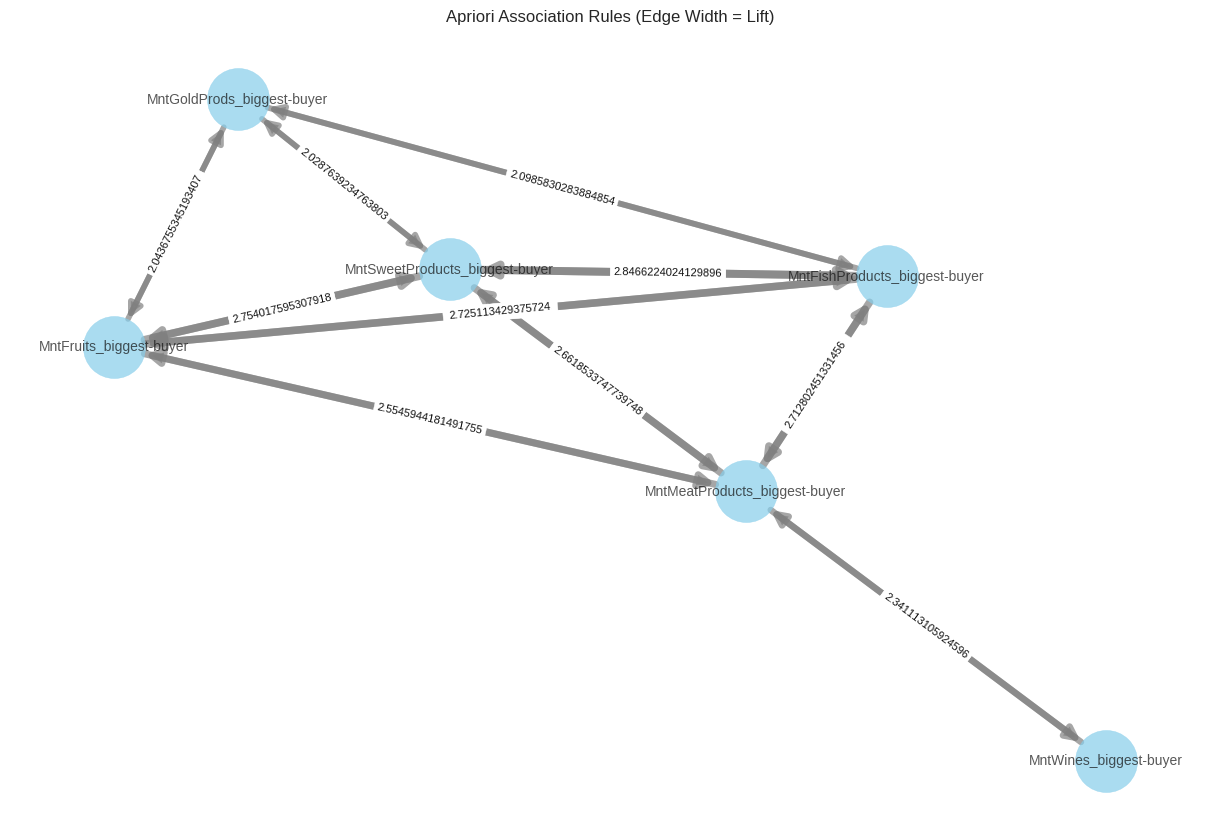

In [ ]:
# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges with lift as weight
for index, row in sorted_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for antecedent in antecedents:
        graph.add_node(antecedent)
    for consequent in consequents:
        graph.add_node(consequent)

    # Add edges for the association rules, using lift as weight
    for antecedent in antecedents:
        for consequent in consequents:
            graph.add_edge(antecedent, consequent, weight=row['lift'])

# Set node positions using spring layout
pos = nx.spring_layout(graph, k=0.5, iterations=50)

# Get edge weights (lift values) for setting edge widths
edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
# Scale edge weights to a suitable range for visualization
edge_widths = [w * 2 for w in edge_weights]  # Adjust the scaling factor as needed

# Draw the graph with edge widths based on lift
plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10,
        edge_color="gray", arrowsize=20, width=edge_widths, alpha=0.7)  # Set width using edge_widths

# Add edge labels for lift values (optional)
edge_labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Apriori Association Rules (Edge Width = Lift)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Business Insights and Recommendation

From our K-Means Segmentaiton and Apriori Algorithm analysis, these are our insights and business recommendation for each cluster.


### Cluster 0 – Low-Spending, Moderate Income, Older Families

**Recommendation**:

* **Introduce value-based bundles** or curated deals for essentials (e.g., meat, wine, household staples).
* **Design loyalty programs** tailored to older or family shoppers (e.g., “Family Saver” or “Senior Advantage”).
* **Invest in educational content** or emails to convert their browsing into purchases.
* **Simplify the purchase path** for this segment, as they may prefer clarity over complexity.

**Product Specific Recommendations**:

* Customer Segment 0 (moderate income) only has associations in the Low Buyer categories for a few of the products, and no higher purchase level associations. We have lowered the minimum support threshold for this category to 0.05 to discover more meaningful product associations for Segment 0.
* In order to market products effectively to this group, we suggest focusing on marketing associated products together for Customer Segment 0. Though this segment does not purchase much, we can effectively increase their purchasing by marketing towards their product associations, rather than individual items, including Wines+Meats, and Fruits+Meats.
*	**The Wines+Meats combination:**
  *	with Customer Segment 0 appears in about 6% of all transactions
  *	is purchased by Customer Segment 0 in about 24% of their transactions
  *	are purchased more often together than by random chance
*	**The Fruits+Meats combination:**
  *	with Customer Segment 0 appears in about 5% of all transactions
  *	is purchased by Customer Segment 0 in about 21% of their transactions
  *	are purchased more often together than by random chance

| Antecedent | Consequent    | Support | Confidence | Lift  |
|------------|--------------|---------|------------|-------|
| Cluster_0  | Wines+Meats  | 0.058   | 0.242      | 2.183 |
| Cluster_0  | Fruits+Meats | 0.051   | 0.210      | 1.852 |

---


### Cluster 1 – Very High-Income, High-Spending, Catalog-Driven Shoppers

**Recommendation**:

* **Focus on premium experiences**: VIP membership, exclusive product previews, and early access.
* **Avoid discount-heavy messaging**; instead, emphasize quality, exclusivity, and service.
* **Cross-sell high-margin luxury items** based on their past purchases (e.g., curated wine/meat boxes).
* **Retain them with personalized thank-you gifts**, concierge support, or anniversary-based campaigns.

**Product Specific Recommendations**:

* Customer Segment 1 (very high income) presents an opportunity to make effective marketing decision that will generate significant returns. This segment has many associations in the Biggest Buyer purchase group, and associations between products in that group.
* In order to market products effectively to this group, we suggest marketing to their top ranked product associations, including Meat+Fish+Sweets, Meat+Fish, Meat+Wine, and individually to Gold.
* **The Meat+Fish+Sweets combination:**
  * with Customer Segment 1 appears in about 10% of all transactions
  *	is purchased by Customer Segment 1 in about 44% of their transactions
  *	are purchased more often together than by random chance
* **The Meat+Fish combination:**
  *	with Customer Segment 1 appears in about 14% of all transactions
  *	is purchased by Customer Segment 1 in about 60% of their transactions
  *	are purchased more often together than by random chance
* **The Meat+Wine combination:**  
  *	with Customer Segment 1 appears in about 12% of all transactions
  *	is purchased by Customer Segment 1 in about 51% of their transactions
  *	are purchased more often together than by random chance
* **Gold:**
  *	with Customer Segment 1 appears in about 11% of all transactions
  *	is purchased by Customer Segment 1 in about 48% of their transactions
  *	are purchased more often together than by random chance

| Antecedent | Consequent         | Support | Confidence |  Lift  |
|------------|--------------------|---------|------------|--------|
| Cluster_1  | Meat+Fish+Sweets   | 0.102   | 0.444      | 3.620  |
| Cluster_1  | Meat+Fish          | 0.138   | 0.599      | 3.611  |
| Cluster_1  | Meat+Wine          | 0.117   | 0.508      | 3.483  |
| Cluster_1  | Gold               | 0.110   | 0.477      | 1.913  |


---

### Cluster 2 – High-Income, Active Shoppers

**Recommendation**:

* **Deploy targeted online promotions and flash sales**, especially via email and web.
* Use **personalized deal recommendations** based on their purchase history and product category preferences.
* Optimize **digital marketing channels** (e.g., paid ads, retargeting, email segmentation).
* **Test loyalty apps or gamified rewards** to deepen engagement and increase order frequency.

**Product Specific Recommendations**:

*	Customer Segment 2 (high income) presents an opportunity to make effective marketing decision that will generate significant returns, similar to Segment 1, however, we suggest focusing on individual product marketing. Purchases associated with Segment 2 include the Biggest Buyer and Frequent Buyer purchase groups. Associated product purchases did not rank highly for Segment 2, however, individual product purchases did.
*	In order to market products effectively to this group, we suggest marketing to their top ranked individual product purchases of Meat, Gold, and Wines
*	**Meat:**
  *	with Customer Segment 2 appears in about 15% of all transactions
  *	is purchased by Customer Segment 2 in about 62% of their transactions
  *	are purchased much more often together than by random chance
*	**Gold:**
  *	with Customer Segment 2 appears in about 12% of all transactions
  *	is purchased by Customer Segment 2 in about 49% of their transactions
  *	are purchased more often together than by random chance
*	**Wines:**
  *	with Customer Segment 0 appears in about 12% of all transactions
  *	is purchased by Customer Segment 2 in about 48% of their transactions
  *	are purchased more often together than by random chance


| Antecedent | Consequent | Support | Confidence |  Lift  |
|------------|------------|---------|------------|--------|
| Cluster_2  | Meat       | 0.151   | 0.624      | 2.490  |
| Cluster_2  | Gold       | 0.118   | 0.485      | 1.948  |
| Cluster_2  | Wines      | 0.115   | 0.476      | 1.904  |

---

### Cluster 3 – Young, Low-Income, Low-Spending Shoppers

**Recommendation**:

* **Build entry-point products** or trial kits to hook first-time buyers.
* Run **“student” or “starter” campaigns** with simple offers like “Buy 1 Get 1” or referral credits.
* Engage this group through **social media and influencer marketing**, where they are more active.
* Invest in **brand-building and awareness**, aiming for long-term retention as their income grows.

**Product Specific Recommendations**:

*	Customer Segment 3 (low income), similar to Segment 0 (moderate income), has no product purchase associations in the Frequent or Biggest Buyer classification, and just a few highly ranked associations in the Low Buyer purchase category. Of the Low Buyer purchase associations, none cover more than one product. We have lowered the minimum support threshold for this category to 0.05 to discover more meaningful product associations for Segment 3.
*	In order to market products effectively to this group, we suggest focusing on marketing associated products together for Customer Segment 3. Though this segment does not purchase much, we can effectively increase their purchasing by marketing towards their product associations, rather than individual items, including Fruits+Sweets, and Wines+Meats.
*	**The Fruits+Sweets combination:**
  *	with Customer Segment 3 appears in about 8% of all transactions
  *	is purchased by Customer Segment 3 in about 27% of their transactions
  *	are purchased more often together than by random chance
*	**The Wines+Meats combination:**
  *	with Customer Segment 3 appears in about 5% of all transactions
  *	is purchased by Customer Segment 3 in about 18% of their transactions
  *	are purchased more often together than by random chance

| Antecedent | Consequent     | Support | Confidence |  Lift  |
|------------|---------------|---------|------------|--------|
| Cluster_0  | Fruits+Sweets | 0.076   | 0.266      | 1.918  |
| Cluster_0  | Meat+Wines    | 0.051   | 0.179      | 1.613  |

---

### Cross-Cluster Product Recommendations

*	When comparing product combination associations we found high ranking associations between several pairs.
*	The majority of the top ranked associations are related to each other by direct or indirect relationships. For example, when isolating the individual product categories such that only one product is associated with another we can see the general relationship amongst all six products categories. Sweets by themselves tend to be bought often with all other individual products except wine, while wine tends to generally be bought with meat and tends not to be paired with other products. Below are some examples of the highest ranked associations with Sweets as the antecedent, and the significant relationships between Sweets-Meat-Wine.
*	Across the largest purchaser group, Biggest Buyers, we suggest allocating a significant amount of marketing resources to targeting customers who purchase fish to provide recommendations to them to buy Fish and Fruits. Recommendations could come through in-app/webapp product recommendations, or by placing these groups near each in store. We also recommend utilizing promotions to sell wine by pairing it with meat, which will then likely result in customers also buy all other products with significant associations with meat.
*	Customers who buy Sweets tend to buy Fish and Fruits more than all other product combinations
  *	in about 13% of all transactions
  *	in about 77% of transactions with sweets as the antecedent
  *	are purchased much more often together than by random chance
*	Customers who buy Sweets tend to buy Meat
  *	in about 17% of all transactions
  *	in about 66% of transactions with sweets as the antecedent
  *	more often together than by random chance
*	Customers who buy Meat tend to buy Wine
  *	in about 15% of all transactions
  *	in about 59% of transactions with meat as the antecedent
  *	more often together than by random chance

| Antecedent | Consequent    | Support | Confidence |  Lift  |
|------------|--------------|---------|------------|--------|
| Sweets     | Fish+Fruits  | 0.127   | 0.769      | 3.082  |
| Sweets     | Meat         | 0.165   | 0.663      | 2.662  |
| Meat       | Wine         | 0.146   | 0.585      | 2.341  |

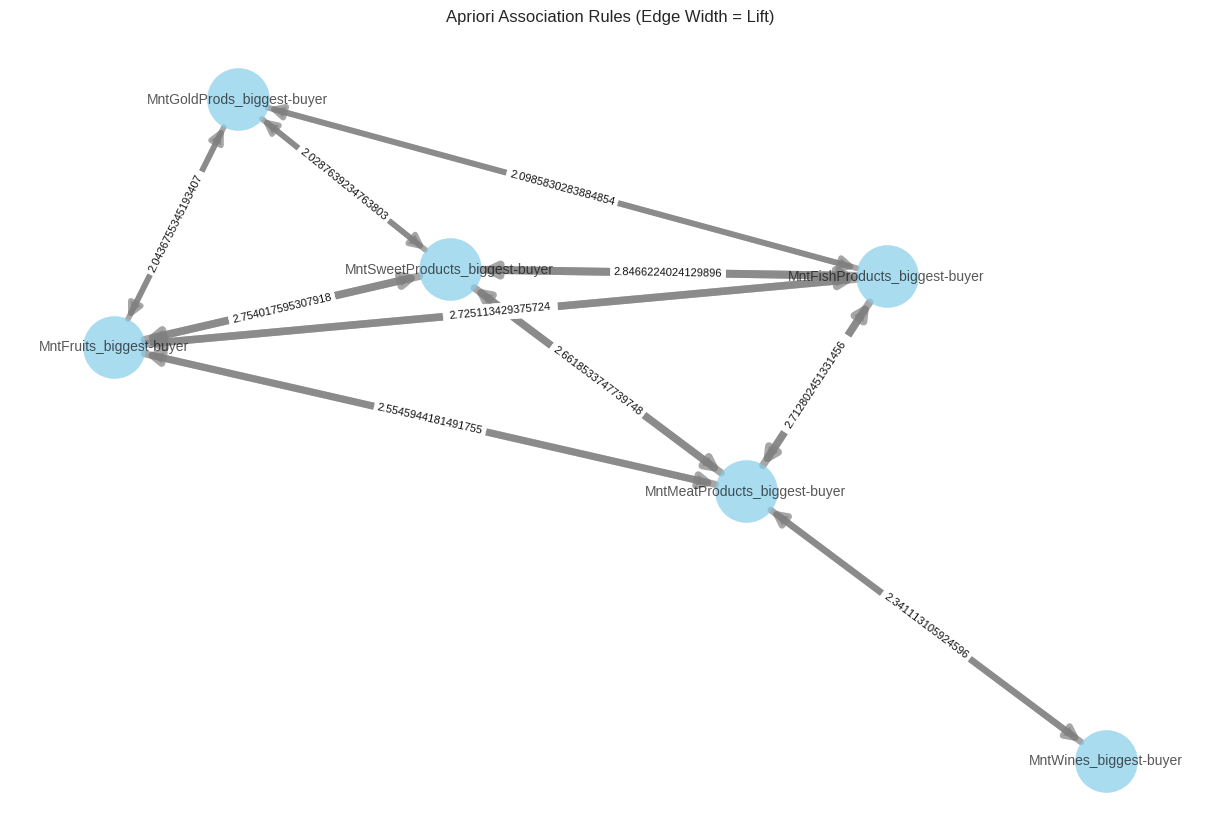

## Overall Business Recommendation

Based on our K-Means customer segmentation and Apriori product association analysis, we recommend a holistic strategy that aims to optimize key business outcomes: **increased sales revenue, improved average order value (AOV), higher marketing efficiency, and stronger customer retention**. These strategies are informed by both purchasing behaviors and product affinities across customer segments.

### 1. Product Bundling Based on Association Rules

Our analysis revealed strong and statistically significant product combinations—such as **Fish and associated products**, **Meat + Fish + Sweets**, and **Meat + Wines**—which are frequently purchased together more often than by random chance across different customer segments.

**Implementation**:

* Design **pre-packaged bundles** using high-lift product combinations for each segment (e.g., “Family Dinner Bundle” for Cluster 0, “Luxury Chef’s Box” for Cluster 1).
* Introduce **"Buy A, get B at 10% off" promotions** using these pairs to increase cart size.

**Expected Business Impact**:

* **↑ Average Order Value (AOV)**: Customers are incentivized to add more to their cart when value or relevance is perceived.
* **↑ Total Revenue**: More comprehensive baskets translate to greater per-transaction revenue.
* **↑ Conversion Rate**: Tailored bundles reduce decision fatigue and align with customer needs, improving purchase likelihood and repeated purchases.

---
### 2. Segment-Based Targeted Marketing

Each cluster exhibits unique behavior and price sensitivity. For instance, Cluster 1 is discount-averse but values exclusivity, while Clusters 2 and 3 respond well to deals and digital promotions.

**Implementation**:

* Deploy **personalized campaigns** that showcase bundle offers or premium experiences based on cluster preferences.
* **Retarget via segmented marketing channels** such as email, ads, loyalty platform. Optimize ad spend especially for Cluster 2 (digitally active) and Cluster 3 (social-media-engaged).
* Segment the customer base using the cluster labels in the CRM system to **customize outreach frequency, channel, and message**.

**Expected Business Impact**:

* **↑ Return on Ad Spend (ROI)**: Tailored campaigns reduce waste and increase response rates.
* **↑ Customer Retention & Lifetime Value**: Personalization boosts perceived relevance and strengthens brand connection. Higher retention means higher lifetime value and higher long-term revenue.
* **↓ Customer Acquisition Cost (CAC)**: Higher conversion efficiency lowers the cost per acquired customer.

---
### 3. Smart Product Placement

The Apriori rules also suggest product adjacency opportunities—such as placing **Sweets near Deli**, or **Meat near Wine**—which can improve cross-selling both in-store and online.

**Implementation**:

* Adjust physical shelf layouts or digital recommendation algorithms to reflect high-confidence product affinities.
* Use machine learning-driven product carousels (e.g., “Customers who bought X also bought Y”) that leverage segment-specific patterns.

**Expected Business Impact**:

* **↑ Basket Size**: Bundled or associated products increase total item count per order.
* **↑ Product Discovery**: Shoppers receive better personalization and user experience.

---
### 4. Product Development and Inventory Strategy

Clusters 1 and 2 show high affinity for luxury products like Gold, Wine, and high-end Meats, while Clusters 0 and 3 favor essential or affordable combinations like Meats + Fruits or Fruits + Sweets.

**Implementation**:

* Use segment demand patterns to inform **new product development** (e.g., introducing premium bundles for Cluster 1 or budget kits for Cluster 3).
* Align **inventory planning** with segment demand to minimize overstock/understock risk.

**Expected Business Impact**:

* **↑ Product-Market Fit**: Launching or promoting products based on behavioral insights increases market responsiveness.
* **↑ Inventory Turnover**: Stocking based on segment-level demand reduces excess.
* **↓ Waste and Holding Costs**: Leaner, data-informed inventory lowers operational cost.
